#import

In [ ]:
import torch
import numpy as np
from statistics import mean
import sys
from torch.utils import *
import argparse
from torch.backends import cudnn
cudnn.benchmark
import pickle
import os
from sklearn.ensemble import RandomForestClassifier
from torchvision.datasets import VisionDataset, CIFAR100
import random
from collections import ChainMap
from PIL import Image
from torch.utils.data import Dataset
import skimage.io as io
import glob
import random
import os.path
import torchvision
from torch import nn
from torch.autograd import Variable
from sklearn.neighbors import KNeighborsClassifier
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch.nn import MSELoss
import math
import torch.utils.model_zoo as model_zoo
from __future__ import print_function, absolute_import
import numpy as np
from six.moves import xrange
from sklearn.utils.validation import check_X_y
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import pairwise_distances_argmin_min,confusion_matrix
import torchvision
import seaborn as sns
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import Compose, CenterCrop, Normalize, Scale, Resize, ToTensor, ToPILImage
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, KLDivLoss, MSELoss  
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import accuracy_score
from sklearn.utils.validation import _num_samples, check_array
import warnings
warnings.filterwarnings('ignore') 
import PIL.Image as Image
from tqdm import tqdm
from matplotlib.ticker import NullFormatter
import matplotlib.pyplot as plt
import json
from copy import deepcopy
from scipy.spatial.distance import cosine

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!nvidia-smi

Fri Jun 26 20:15:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#dataset


In [ ]:
np.random.seed(1993) 
order = np.arange(100)
np.random.shuffle(order)
print(order)
label_map = {k: v for v, k in enumerate(order)}
print(label_map)

train = CIFAR100('.data/', train=True, transform=None, download=True)
test = CIFAR100('.data/', train=False, transform=None, download=True)

class Cifar100:
    def __init__(self, train, test):
        self.train = train
        self.test = test
        self.train_groups, self.test_groups = self.split()
        self.batch_num = 10

    def split(self):
        train_groups = [[],[],[],[],[],[],[],[],[],[]]
        for data, target in self.train:
            if target in order[:10]:
                train_groups[0].append((data,target))
            elif target in order[10:20]:
                train_groups[1].append((data,target))
            elif target in order[20:30]:
                train_groups[2].append((data,target))
            elif target in order[30:40]:
                train_groups[3].append((data,target))
            elif target in order[40:50]:
                train_groups[4].append((data,target))
            elif target in order[50:60]:
                train_groups[5].append((data,target))
            elif target in order[60:70]:
                train_groups[6].append((data,target))
            elif target in order[70:80]:
                train_groups[7].append((data,target))
            elif target in order[80:90]:
                train_groups[8].append((data,target))
            elif target in order[90:100]:
                train_groups[9].append((data,target))

        test_groups = [[],[],[],[],[],[],[],[],[],[]]
        for data, target in self.test:
            if target in order[:10]:
                test_groups[0].append((data,target))
            elif target in order[10:20]:
                test_groups[1].append((data,target))
            elif target in order[20:30]:
                test_groups[2].append((data,target))
            elif target in order[30:40]:
                test_groups[3].append((data,target))
            elif target in order[40:50]:
                test_groups[4].append((data,target))
            elif target in order[50:60]:
                test_groups[5].append((data,target))
            elif target in order[60:70]:
                test_groups[6].append((data,target))
            elif target in order[70:80]:
                test_groups[7].append((data,target))
            elif target in order[80:90]:
                test_groups[8].append((data,target))
            elif target in order[90:100]:
                test_groups[9].append((data,target))

        return train_groups, test_groups

    def next_classes_batch(self, i):
        return self.train_groups[i], self.test_groups[i]

if __name__ == "__main__":
    cifar = Cifar100(train, test)
    print(len(cifar.train_groups[0]))

[68 56 78  8 23 84 90 65 74 76 40 89  3 92 55  9 26 80 43 38 58 70 77  1
 85 19 17 50 28 53 13 81 45 82  6 59 83 16 15 44 91 41 72 60 79 52 20 10
 31 54 37 95 14 71 96 98 97  2 64 66 42 22 35 86 24 34 87 21 99  0 88 27
 18 94 11 12 47 25 30 46 62 69 36 61  7 63 75  5 32  4 51 48 73 93 39 67
 29 49 57 33]
{68: 0, 56: 1, 78: 2, 8: 3, 23: 4, 84: 5, 90: 6, 65: 7, 74: 8, 76: 9, 40: 10, 89: 11, 3: 12, 92: 13, 55: 14, 9: 15, 26: 16, 80: 17, 43: 18, 38: 19, 58: 20, 70: 21, 77: 22, 1: 23, 85: 24, 19: 25, 17: 26, 50: 27, 28: 28, 53: 29, 13: 30, 81: 31, 45: 32, 82: 33, 6: 34, 59: 35, 83: 36, 16: 37, 15: 38, 44: 39, 91: 40, 41: 41, 72: 42, 60: 43, 79: 44, 52: 45, 20: 46, 10: 47, 31: 48, 54: 49, 37: 50, 95: 51, 14: 52, 71: 53, 96: 54, 98: 55, 97: 56, 2: 57, 64: 58, 66: 59, 42: 60, 22: 61, 35: 62, 86: 63, 24: 64, 34: 65, 87: 66, 21: 67, 99: 68, 0: 69, 88: 70, 27: 71, 18: 72, 94: 73, 11: 74, 12: 75, 47: 76, 25: 77, 30: 78, 46: 79, 62: 80, 69: 81, 36: 82, 61: 83, 7: 84, 63: 85, 75: 86, 5: 87, 32: 88, 

Extracting .data/cifar-100-python.tar.gz to .data/

Files already downloaded and verified
5000


In [ ]:
class BatchData(Dataset):
    def __init__(self, images, labels, input_transform=None):
        self.images = images
        self.labels = labels
        self.input_transform = input_transform

    def __getitem__(self, index):
        image = self.images[index]
        image = Image.fromarray(np.uint8(image))
        label = self.labels[index]
        label = label_map[label]
        if self.input_transform is not None:
          image = self.input_transform(image)
        
        label = torch.LongTensor([label])
        return image, label

    def __len__(self):
        return len(self.images)

#exemplar


In [ ]:
class Exemplar:
    def __init__(self, max_size, total_cls): 
        self.train = {}
        self.cur_cls = 0
        self.max_size = max_size
        self.total_classes = total_cls
        self.store_num = {}
        self.count_train = {}

    def update(self, cls_num, train, inc_i):
        train_x, train_y = train
        cur_keys = list(set(train_y))
        print(cur_keys)
        def countX(tup, x): 
            count = 0
            for ele in tup: 
              if (ele == x): 
                count = count + 1
            return count 
        
        self.cur_cls = cls_num

        for i in order[inc_i*10: 10*(inc_i+1)]:      # cambia range ad ogni step
            self.count_train[i] = countX(train_y, i)     
            self.store_num[i] = int(self.count_train[i] / ((self.cur_cls)*0.1))

        total_store_num = self.max_size / self.cur_cls #if self.cur_cls != 0 else max_size
        train_store_num = int(total_store_num)  # ha senso?

        for x, y in zip(train_x, train_y):
            if y not in self.train:
                self.train[y] = [x]
            else:
                if len(self.train[y]) < train_store_num:
                    self.train[y].append(x)
        assert self.cur_cls == len(list(self.train.keys()))
        
        for key, value in self.train.items():
            self.train[key] = value[:train_store_num]
        for key, value in self.train.items():
            assert len(self.train[key]) == train_store_num      # ==!


    def get_exemplar_train(self):
        exemplar_train_x = []
        exemplar_train_y = []
        for key, value in self.train.items():
            for train_x in value:
                exemplar_train_x.append(train_x)
                exemplar_train_y.append(key)
        return exemplar_train_x, exemplar_train_y

#resnet32

In [ ]:
"""
Credits to @hshustc
Taken from https://github.com/hshustc/CVPR19_Incremental_Learning/tree/master/cifar100-class-incremental
"""


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes):
        self.old_model = None
        self.num_classes = num_classes
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Linear(64 * block.expansion, self.num_classes)
  

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, features=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        if features:
            x = x / x.norm()
        else:
            x = self.fc(x)

        return x
        
def resnet20(pretrained=False, **kwargs):
    n = 3
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet32(pretrained=False, **kwargs):
    n = 5
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet56(pretrained=False, **kwargs):
    n = 9
    model = ResNet(Bottleneck, [n, n, n], **kwargs)
    return model

#model

In [ ]:
class Trainer:
    def __init__(self, total_cls):
        self.total_cls = total_cls
        self.seen_cls = 0
        self.dataset = Cifar100(train, test)
        self.model = resnet32(num_classes = total_cls).cuda()
        self.count_label = {}
        self.means = {}
        transform_train = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
        ]
        transform_train.extend([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])
        self.input_transform = Compose(transform_train)
        
        self.input_transform_eval = Compose([
                                ToTensor(),
                                Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010))])
        total_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print("Solver total trainable parameters : ", total_params)


    def test(self, testdata):
        self.model.eval()
        count = 0
        correct = 0
        wrong = 0
        with torch.no_grad():
          for i, (image, label) in enumerate(testdata):
              image = image.cuda()
              label = label.view(-1).cuda()
              p = self.model(image)
              pred = p[:,:self.seen_cls].argmax(dim=-1)
              correct += sum(pred == label).item()
              wrong += sum(pred != label).item()
        acc = correct / (wrong + correct)
        print(f"\r Test Acc: {acc*100} \n")
        return acc

    def NMEClassifier(self, test_dataloader, train_loader):
      self.model.eval()
      with torch.no_grad():
        for i in range(0,self.seen_cls):
          t=0
          mean = torch.zeros((1,64),device='cuda')
          for indices,(images,labels) in enumerate((train_loader)):
            images = images.to('cuda')
            outputs = self.model(images,features=True)
            for output,key in zip(outputs,labels):
              if i==key:
                mean+=output
                t+=1
          mean = mean/t
          self.means[i] = mean / mean.norm()
        running_corrects = 0
        y_for_mat,y2_for_mat=[],[]
        for images,labels in test_dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            features = self.model(images,features=True)
            for i,sample in enumerate(features):
                c=[]
                for k,v in self.means.items():
                  temp=torch.dot(torch.squeeze(v), sample).data
                  c.append(temp)
                matx=torch.tensor(c)
                y_pred = torch.argmax(matx).item()
                y_for_mat.append(y_pred)
                y2_for_mat.append(labels[i].cpu().numpy())
                if y_pred == labels[i] : 
                    running_corrects+=1
        mat = confusion_matrix(y2_for_mat,y_for_mat)
        accuracy_eval = running_corrects / (100*self.seen_cls)   
        print(f'Accuracy on eval NME:{accuracy_eval*100}' )

        return accuracy_eval,mat

    def CSClassifier(self, test_dataloader, train_loader):
      self.model.eval()
      with torch.no_grad():
        for i in range(0,self.seen_cls):
          t=0
          mean = torch.zeros((1,64),device='cuda')
          for indices,(images,labels) in enumerate((train_loader)):
            images = images.to('cuda')
            outputs = self.model(images,features=True)
            for output,key in zip(outputs,labels):
              if i==key:
                mean+=output
                t+=1
          mean = mean/t
          self.means[i] = mean / mean.norm()
        correct = 0.0
        mat_lab,mat_pred=[],[]
        for images, labels in test_dataloader:
          images = images.to('cuda')
          outputs = self.model(images,features=True)
          preds = []
          for output in outputs:
            min_d = 99999999999999
            for k,v in self.means.items():
              dist=cosine(v.cpu(),output.cpu())
              if dist<min_d:
                min_d=dist
                pred=k
            preds.append(pred)
          mat_lab+=list(labels.cpu().numpy())
          mat_pred+=preds
          for label, pred in zip(labels,preds):
            if label == pred:
              correct += 1
      
      accuracy = correct/(self.seen_cls*100)
      print(f'Cosine Similarity Accuracy: {accuracy*100}')
      mat = confusion_matrix(mat_lab,mat_pred)
      return accuracy,mat

    def SVMClassifier(self,test_loader,train_loader):
      self.model.eval()
      x_train=[]
      y_train=[]
      x_test=[]
      y_test=[]
      with torch.no_grad():
        for i, (images, labels) in enumerate((train_loader)):
          images = images.to('cuda')
          with torch.no_grad():
            outputs = self.model(images,features=True)
            for output,label in zip(outputs,labels):
              x_train.append(np.array(output.to('cpu')))
              y_train.append(np.array(label))
        n_correct = 0.0
        for i, (images, labels) in enumerate((test_loader)):
          images = images.to('cuda')
          with torch.no_grad():
            outputs = self.model(images,features=True)
            for output,label in zip(outputs,labels):
              x_test.append(np.array(output.to('cpu')))
              y_test.append(np.array(label))
      svc = SVC(random_state=42, C=1)
      svc.fit(x_train, y_train)
      y_pred=svc.predict(x_test)
      acc= accuracy_score(y_test, y_pred)
      mat = confusion_matrix(y_test,y_pred)
      print(f'accuracy SVC:{acc*100}')
      return acc,mat

    def KNNClassifier(self,test_loader,train_loader):
      self.model.eval()
      x_train=[]
      y_train=[]
      x_test=[]
      y_test=[]
      with torch.no_grad():
        for i, (images, labels) in enumerate((train_loader)):
          images = images.to('cuda')
          with torch.no_grad():
            outputs = self.model(images,features=True)
            for output,label in zip(outputs,labels):
              x_train.append(np.array(output.to('cpu')))
              y_train.append(np.array(label))
        n_correct = 0.0
        for i, (images, labels) in enumerate((test_loader)):
          images = images.to('cuda')
          with torch.no_grad():
            outputs = self.model(images,features=True)
            for output,label in zip(outputs,labels):
              x_test.append(np.array(output.to('cpu')))
              y_test.append(np.array(label))
      clf = KNeighborsClassifier()
      clf.fit(x_train, y_train)
      y_pred=clf.predict(x_test)
      acc= accuracy_score(y_test, y_pred)
      mat = confusion_matrix(y_test,y_pred)
      print(f'accuracy KNN:{acc*100}')
      return acc,mat

    def get_lr(self, optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']

    def train(self, batch_size, epoches, lr, max_size):
        total_cls = self.total_cls
        criterion = CrossEntropyLoss()
        #criterion = BCEWithLogitsLoss()
        accs_nme=[]
        accs_svm=[]
        accs_KNN=[]
        accs_cos=[]
        previous_model = None
        exemplar = Exemplar(max_size, total_cls)
        dataset = self.dataset
        test_xs = []
        test_ys = []
        train_xs = []
        train_ys = []

        for inc_i in range(dataset.batch_num):
            print(50*'---')
            print(" Incremental batch num: " , inc_i)
            train, test = dataset.next_classes_batch(inc_i)
            train_x, train_y = zip(*train)
            test_x, test_y = zip(*test)
            test_xs.extend(test_x)
            test_ys.extend(test_y)
 

            if inc_i > 0:
               train_xs, train_ys = exemplar.get_exemplar_train()
               ex_data = DataLoader(BatchData(train_xs, train_ys, input_transform=self.input_transform), batch_size=128, shuffle=False, drop_last=True)

            train_xs.extend(train_x)
            train_ys.extend(train_y)  

            def countX(tup, x): 
              count = 0
              for ele in tup: 
                if (ele == x): 
                  count = count + 1
              return count 
        

            for i in order[inc_i*10: 10*(inc_i+1)]:      # cambia range ad ogni step
              self.count_label[i] = countX(train_ys, i)     

            print(len(list(self.count_label.keys())))
              
            self.seen_cls = (total_cls//dataset.batch_num)*(inc_i + 1)
            print("Seen cls number: ", self.seen_cls)                            

            train_data = DataLoader(BatchData(train_xs, train_ys, input_transform=self.input_transform),
                        batch_size=batch_size, shuffle=True, drop_last=True)
            test_data = DataLoader(BatchData(test_xs, test_ys, input_transform=self.input_transform_eval),
                        batch_size=batch_size, shuffle=False)

            optimizer = optim.SGD(self.model.parameters(), lr=0.2, momentum=0.9,  weight_decay=2e-4)
            scheduler = MultiStepLR(optimizer, milestones=[40, 60], gamma=0.2)

            for epoch in range(epoches):
                cur_lr = self.get_lr(optimizer)
                print(f"\r EPOCH:{epoch}, LR:{cur_lr}", end='')
                if inc_i > 0:
                   self.distill(train_data, criterion, optimizer, inc_i)
                   scheduler.step()
                else:
                   self.stage_1(train_data, criterion, optimizer)
                   scheduler.step()

            self.previous_model = deepcopy(self.model)
            if inc_i > 0:
              acc1,mat1= self.SVMClassifier(test_data,train_data)
              acc2,mat2 = self.NMEClassifier(test_data,train_data)
              acc3,mat3 = self.CSClassifier(test_data,train_data)
              acc4,mat4 = self.KNNClassifier(test_data,train_data)
              accs_svm.append(acc1)
              accs_nme.append(acc2)
              accs_cos.append(acc3)
              accs_KNN.append(acc4)
            else:
              acc = self.test(test_data)
              accs_svm.append(acc)
              accs_nme.append(acc)
              accs_cos.append(acc)
              accs_KNN.append(acc)
            if inc_i==9:
              fig, ax = plt.subplots()
              ax = sns.heatmap(mat1)
              plt.show()
              fig, ax = plt.subplots()
              ax = sns.heatmap(mat2)
              plt.show()
              fig, ax = plt.subplots()
              ax = sns.heatmap(mat3)
              plt.show()
              fig, ax = plt.subplots()
              ax = sns.heatmap(mat4)
              plt.show()

            print(f'SVM:{accs_svm} and mean:{mean(accs_svm)}')
            print(f'NME:{accs_nme}and mean:{mean(accs_nme)}')
            print(f'COSINE SIMILARITY:{accs_cos}and mean:{mean(accs_cos)}')
            print(f'KNN:{accs_KNN}and mean:{mean(accs_KNN)}')
            
            x_ex, y_ex = self.exemplar_selection(train_x, train_y)   
            exemplar.update(self.seen_cls, (x_ex, y_ex), inc_i)


         
        fig, ax = plt.subplots()
        line1 = ax.plot(range(1, len(accs_svm)+1), accs_svm, label = 'Test accuracy SVM')
        ax.set(xlabel='N. Classes')
        ax.grid()
        ax.legend()
        plt.show()

        fig, ax = plt.subplots()
        line1 = ax.plot(range(1, len(accs_nme)+1), accs_nme, label = 'Test accuracy  NME')
        ax.set(xlabel='N. Classes')
        ax.grid()
        ax.legend()
        plt.show()

        fig, ax = plt.subplots()
        line1 = ax.plot(range(1, len(accs_cos)+1), accs_cos, label = 'Test accuracy cosine similarity')
        ax.set(xlabel='N. Classes')
        ax.grid()
        ax.legend()
        plt.show()

        fig, ax = plt.subplots()
        line1 = ax.plot(range(1, len(accs_KNN)+1), accs_KNN, label = 'Test accuracy  KNN')
        ax.set(xlabel='N. Classes')
        ax.grid()
        ax.legend()
        plt.show()

    def cod_one_hot(self, x):
        batch_size = 128
        y_one_hot = torch.zeros(len(x), self.seen_cls).cuda()
        y_one_hot = y_one_hot.scatter(1,x.long().view(-1,1).cuda(),1).cuda()
        return y_one_hot


    def stage_1(self, train_data, criterion, optimizer):
        self.model.train()
        losses = []
        for i, (image, label) in enumerate((train_data)):
            image = image.cuda()
            label = label.cuda().view(-1)
            #label = self.cod_one_hot(label)
            p = self.model(image)
            loss = criterion(p[:,:self.seen_cls], label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def exemplar_selection(self,x,y): #Per una classe set di exemplars
        set_class=list(set(y))
        m=round(2000/self.seen_cls)
        means = dict.fromkeys(set_class)
        map = dict.fromkeys(set_class)
        exemplars = dict.fromkeys(set_class)
        for label in map:
          map[label] =  []
          exemplars[label] = []
        for item,la in zip(x,y):
          for label in map:
            if la == label:
              map[label].append(item)
        self.model.eval()
        X_exemplars=[]
        y_exemplars=[]
        for label in map:
          mean = torch.zeros((1,64),device='cuda')
          class_outputs = []
          tr_y=[label]*len(map[label])
          with torch.no_grad():
            loader = DataLoader(BatchData(map[label],tr_y , input_transform=self.input_transform_eval),batch_size=128, shuffle=False,num_workers=4,drop_last=False)
            for images, _ in loader:
                images = images.to('cuda')
                outputs = self.model(images,features=True)
                for output in outputs:
                    output = output.to('cuda')
                    class_outputs.append(output.data.cpu().numpy())
                    mean += output
            mean = mean / len(map[label])
            means[label] = mean / mean.norm()
          feat_ex = []
          features = np.array(class_outputs)
          features = np.array(F.normalize(torch.tensor(features)))
          X = features
          pca = PCA(n_components=2, random_state=0)
          X = pca.fit_transform(X)
          indexing= []
          for i in range(m):
            s=np.sum(feat_ex, axis=0)
            exs_mean = (features + s)/(i+1) 
            exs_mean = F.normalize(torch.tensor(exs_mean).to('cuda'))
            ind = np.argsort( np.sqrt( np.sum((means[label].cpu().numpy() - exs_mean.cpu().numpy())**2, axis=1) ) )
            flag=True
            for el in ind:
              if (el not in indexing) and (flag==True):
                indexing.append(el)
                feat_ex.append(features[el])
                X_exemplars.append(map[label][el])
                y_exemplars.append(label)
                flag=False

            print(f'\r{i}/{m} exemplars for class: {label} and {len(X_exemplars)} total exemplars ', end='')

          (fig, subplots) = plt.subplots(1,2,figsize=(12, 6))
          ax = subplots[0]
          ax.set_title("Feature representation of images from class: %d" % label)
          ax.scatter(X[:, 0], X[:, 1])
          ax.xaxis.set_major_formatter(NullFormatter())
          ax.yaxis.set_major_formatter(NullFormatter())
          ax = subplots[1]
          ax.set_title("Exemplars for class: %d" % label)
          ax.scatter(X[i_added, 0], X[i_added, 1])
          ax.xaxis.set_major_formatter(NullFormatter())
          ax.yaxis.set_major_formatter(NullFormatter())
        return X_exemplars,y_exemplars

    def distill(self, train_data, criterion, optimizer, inc_i):
        self.model.train()
        distill_losses = []
        for i, (image, label) in enumerate((train_data)):
            image = image.cuda()
            label = label.cuda().view(-1)
            p = self.model(image)
            with torch.no_grad():
                pre_p = self.previous_model(image)    
            pre_p = F.softmax(pre_p[:,:self.seen_cls-10], dim=1)
            dist_loss = BCEWithLogitsLoss()(p[:,:self.seen_cls-10], pre_p)
            class_loss = criterion(p[:,:self.seen_cls], label)
            loss = class_loss + dist_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
import subprocess
print(subprocess.getoutput('nvidia-smi'))

Fri Jun 26 20:15:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#main

Solver total trainable parameters :  472756
------------------------------------------------------------------------------------------------------------------------------------------------------
 Incremental batch num:  0
10
Seen cls number:  10
 Test Acc: 88.2 

SVM:[0.882] and mean:0.882
NME:[0.882]and mean:0.882
COSINE SIMILARITY:[0.882]and mean:0.882
KNN:[0.882]and mean:0.882
199/200 exemplars for class: 90 and 2000 total exemplars [65, 68, 8, 74, 76, 78, 84, 23, 56, 90]
------------------------------------------------------------------------------------------------------------------------------------------------------
 Incremental batch num:  1
20
Seen cls number:  20
 EPOCH:69, LR:0.008000000000000002accuracy SVC:74.0
Accuracy on eval NME:76.1
Cosine Similarity Accuracy: 76.25
accuracy KNN:74.3
SVM:[0.882, 0.74] and mean:0.8109999999999999
NME:[0.882, 0.761]and mean:0.8215
COSINE SIMILARITY:[0.882, 0.7625]and mean:0.8222499999999999
KNN:[0.882]and mean:0.882
99/100 exemplars for 

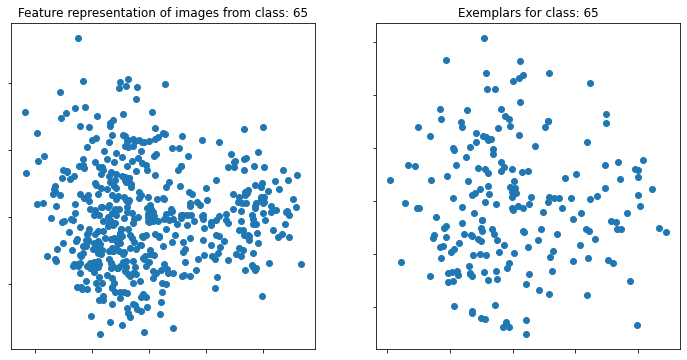

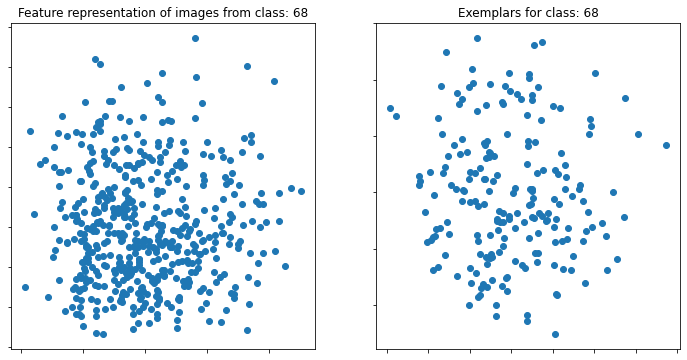

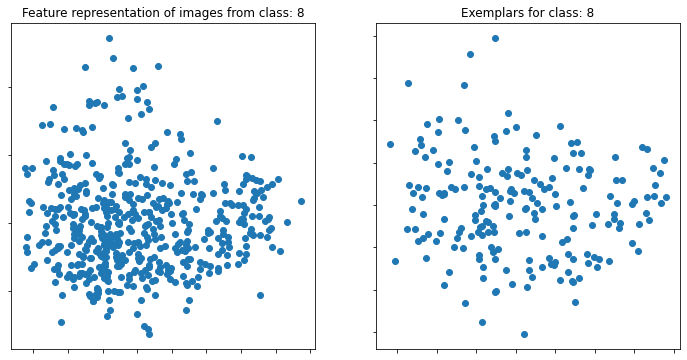

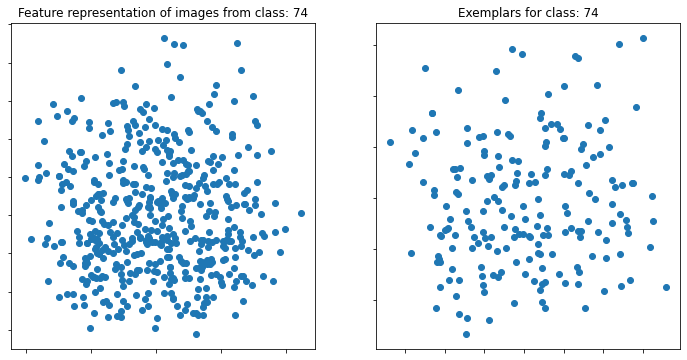

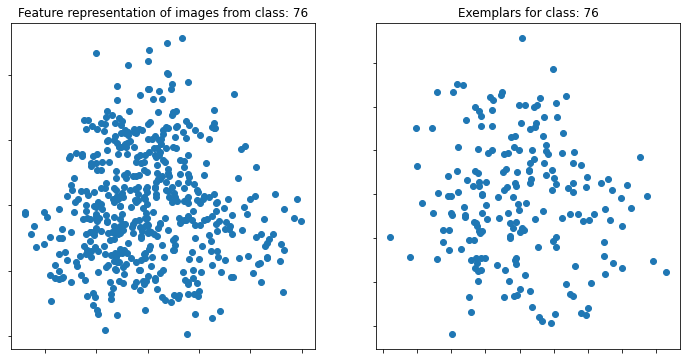

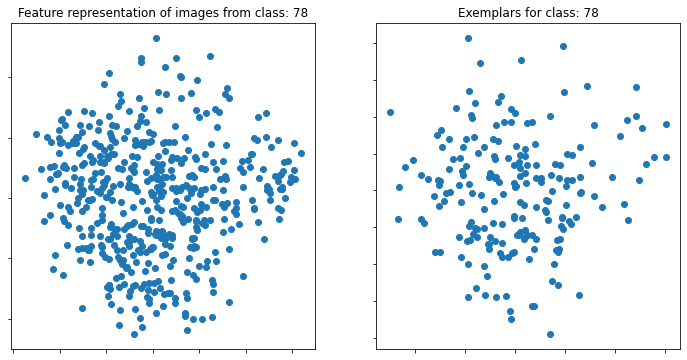

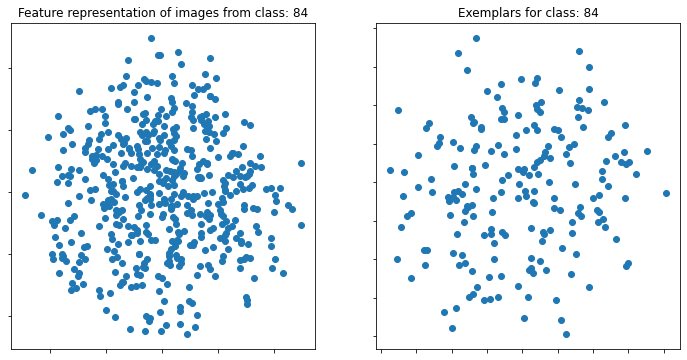

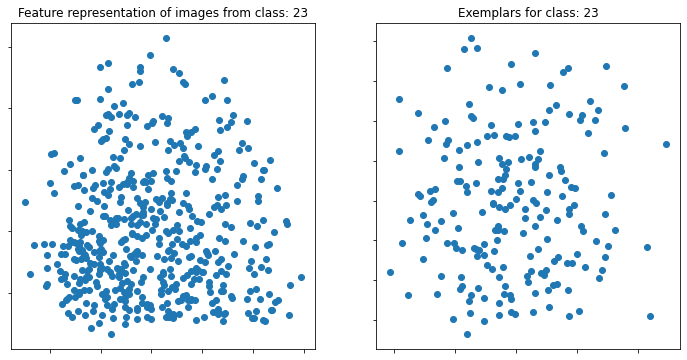

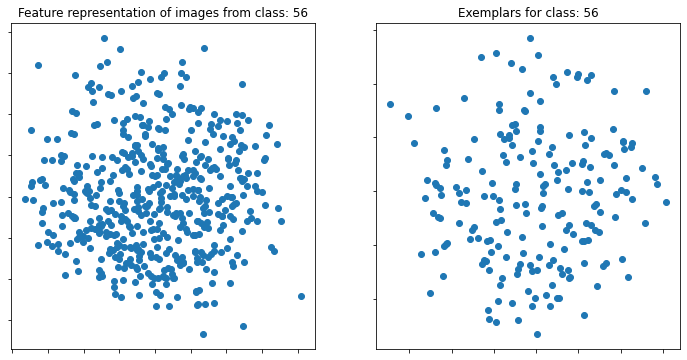

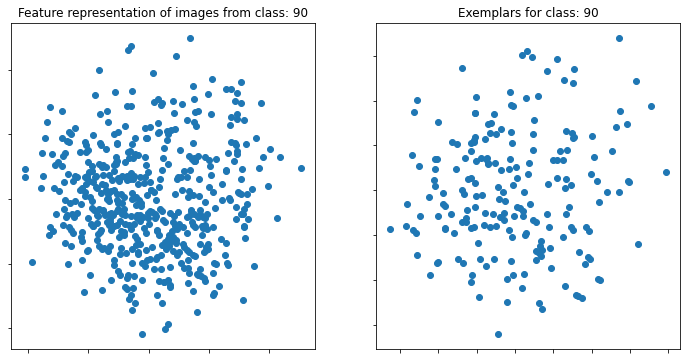

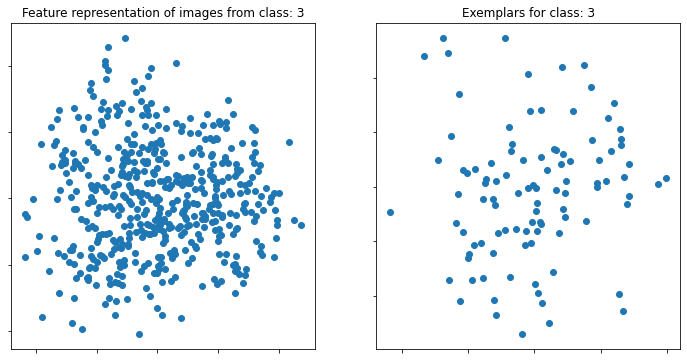

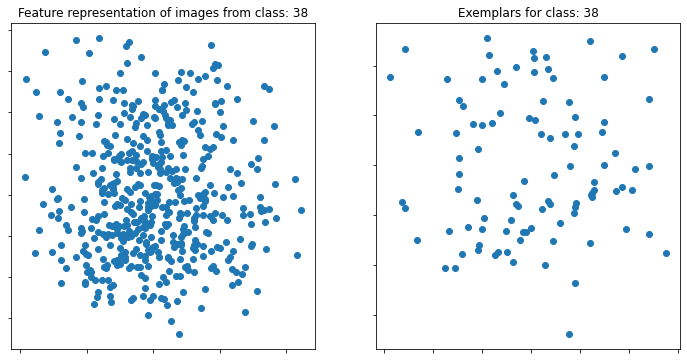

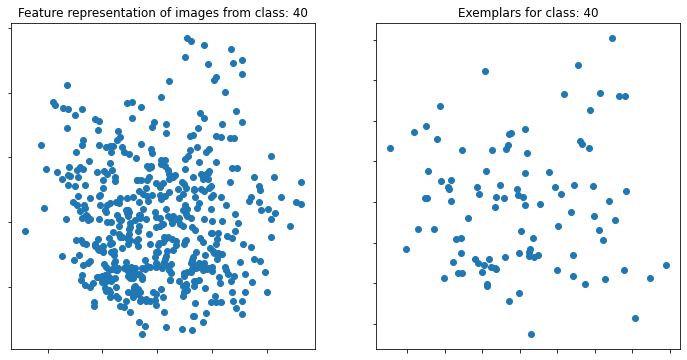

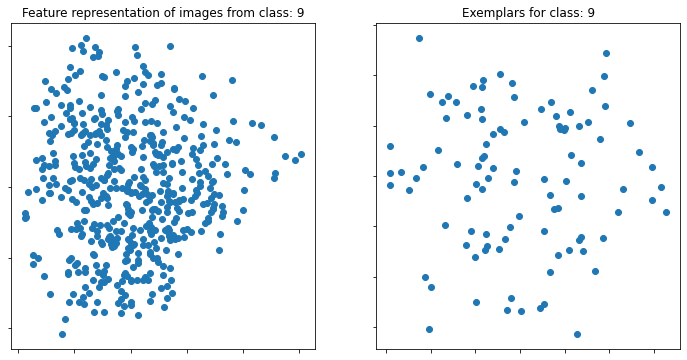

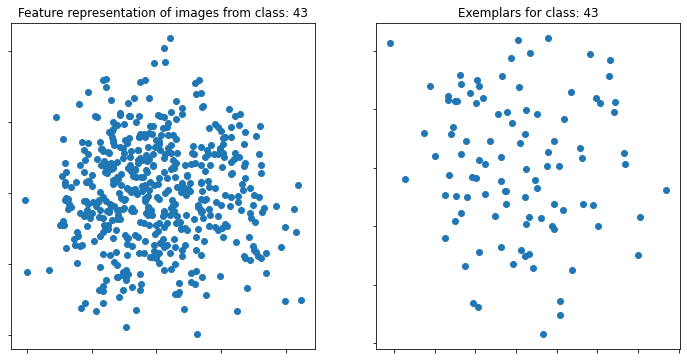

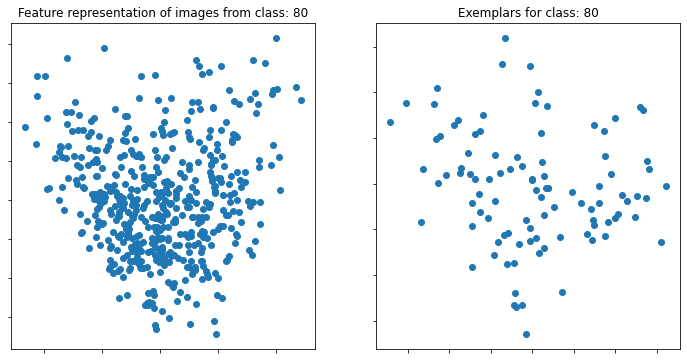

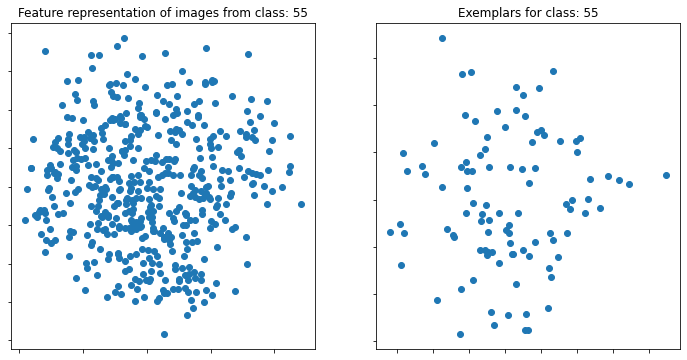

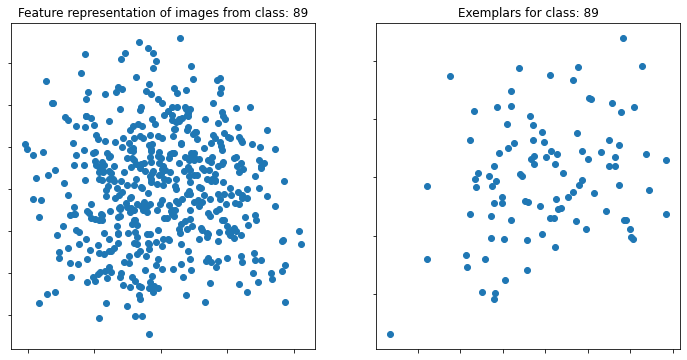

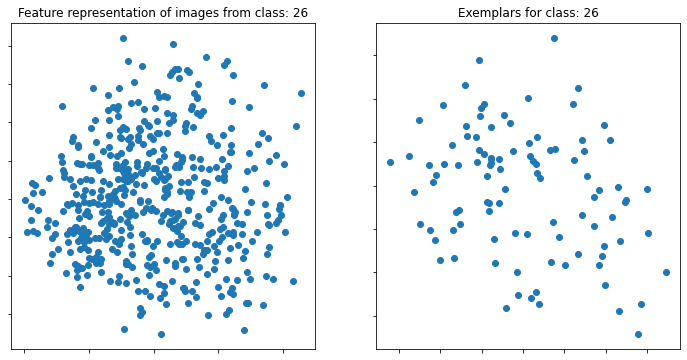

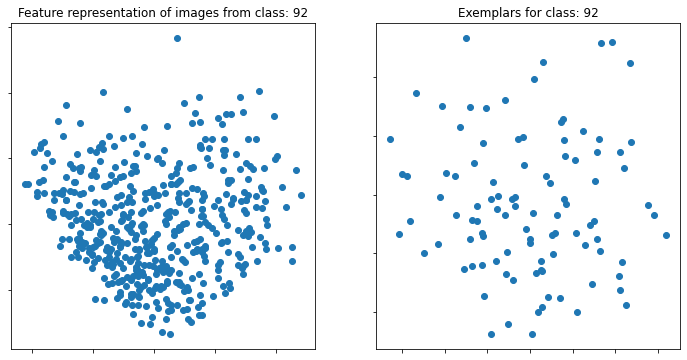

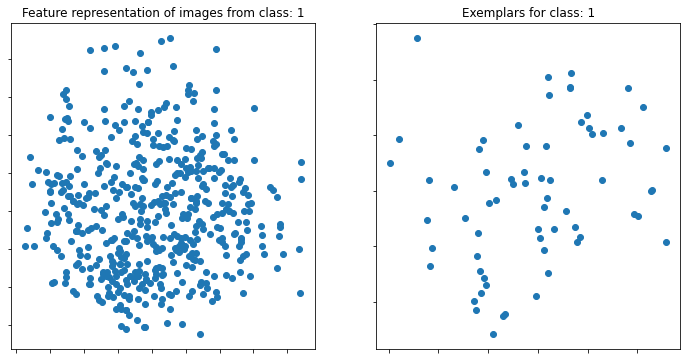

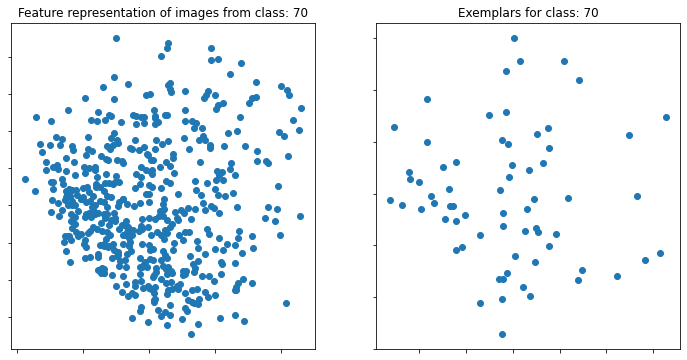

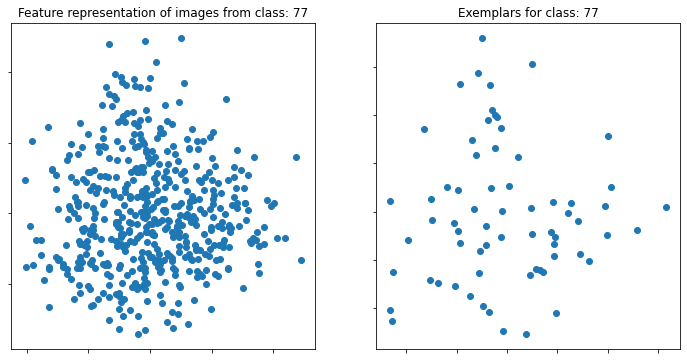

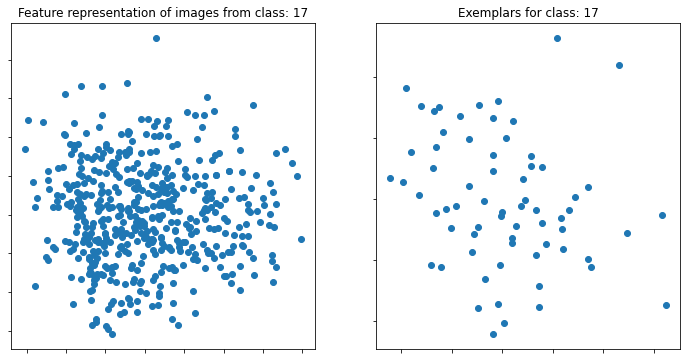

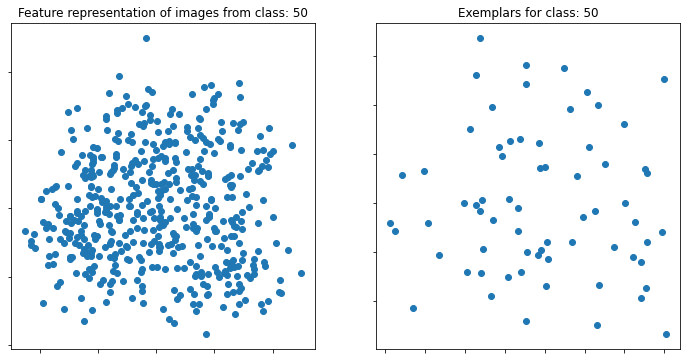

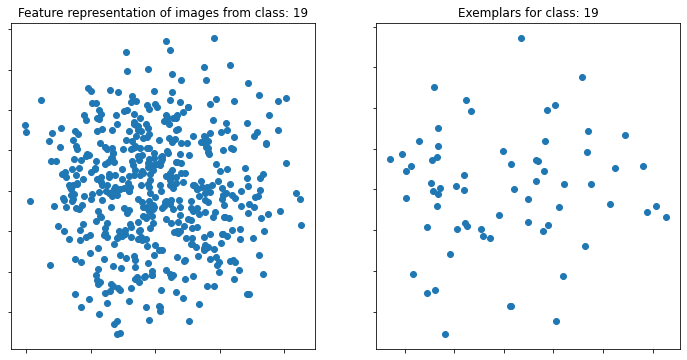

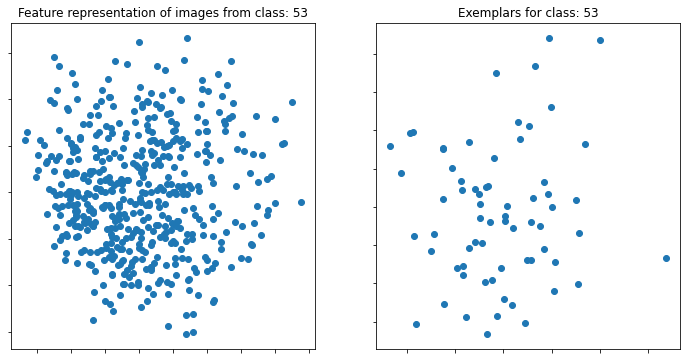

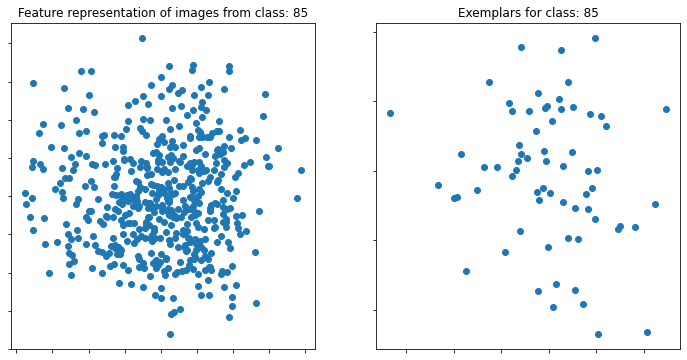

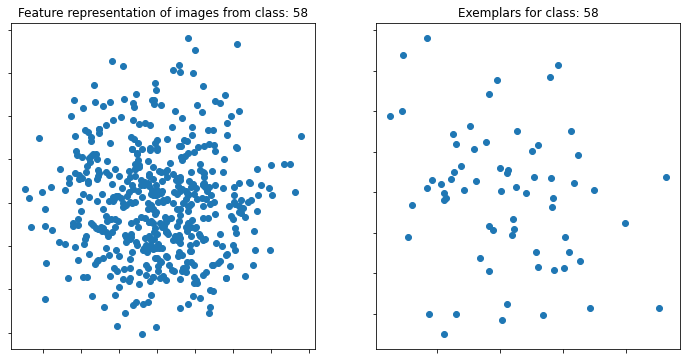

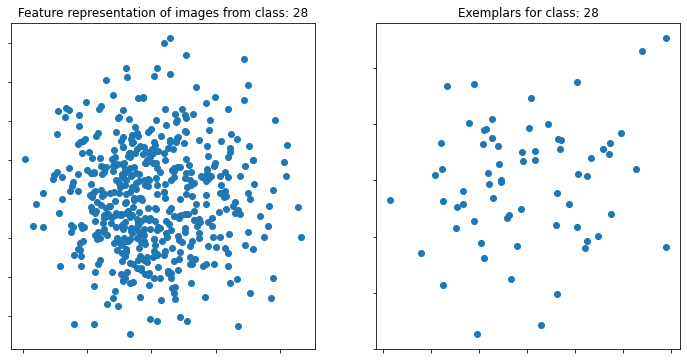

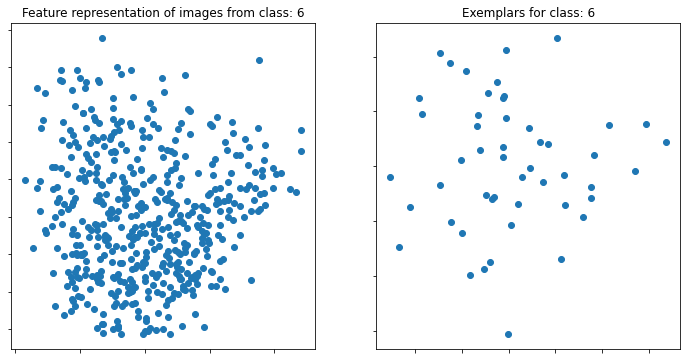

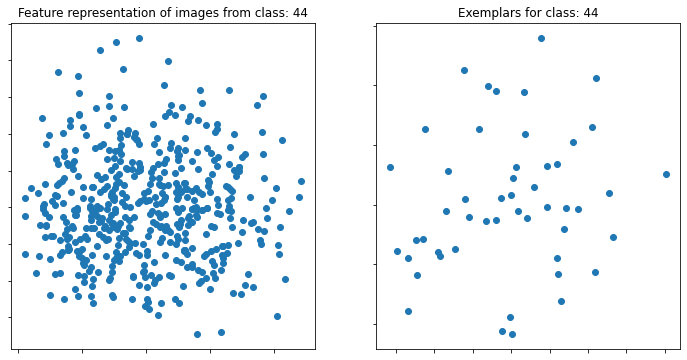

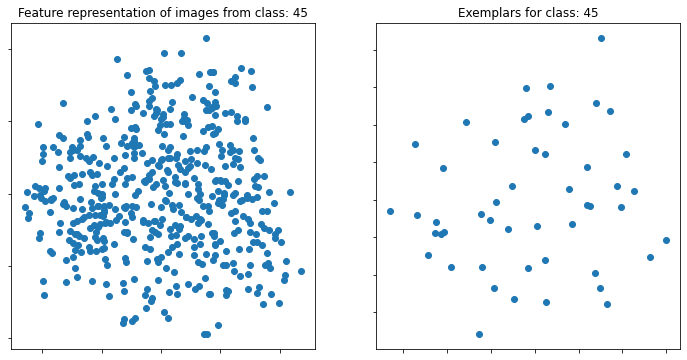

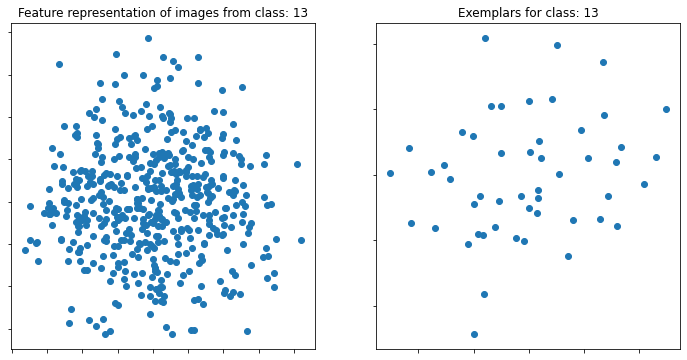

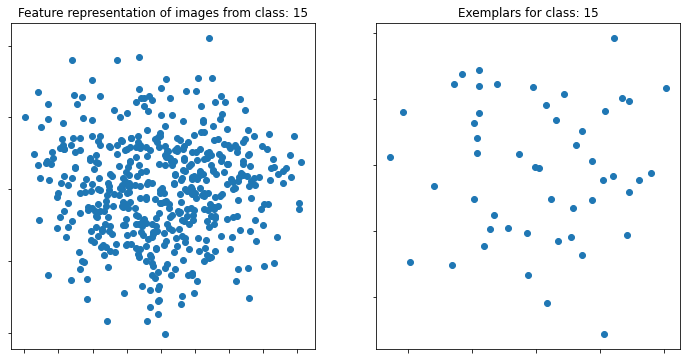

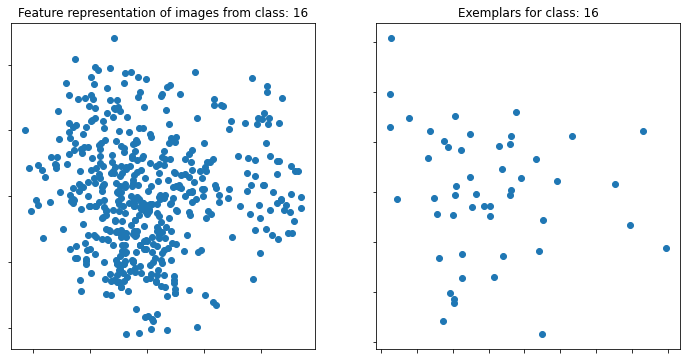

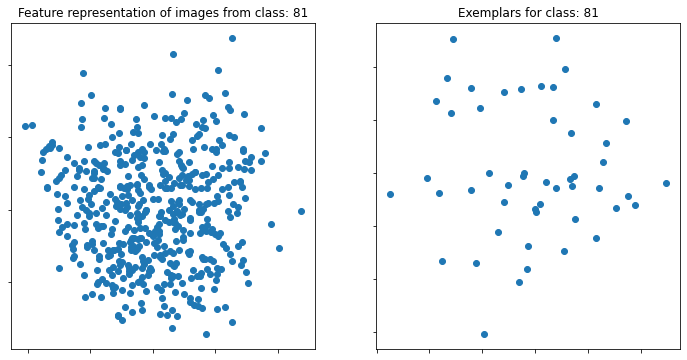

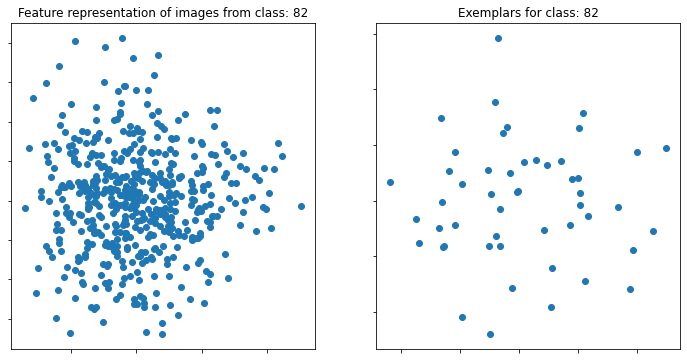

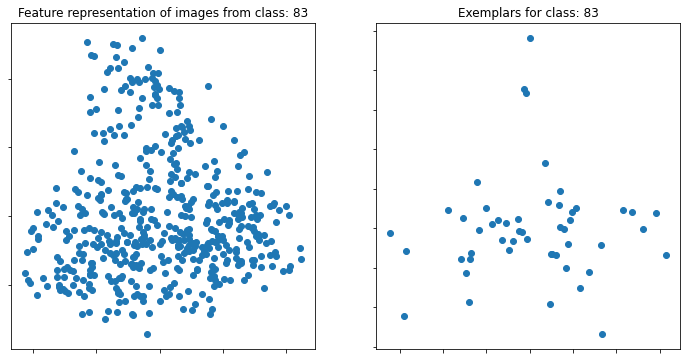

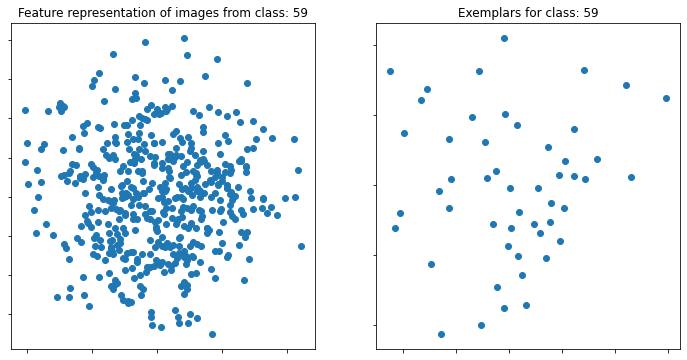

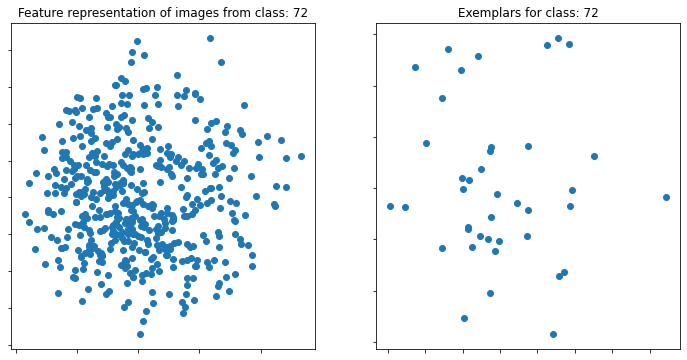

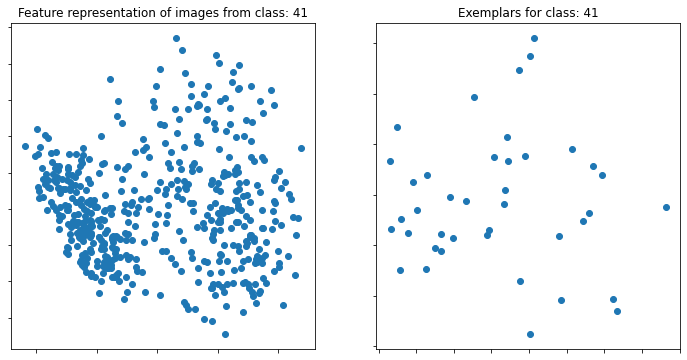

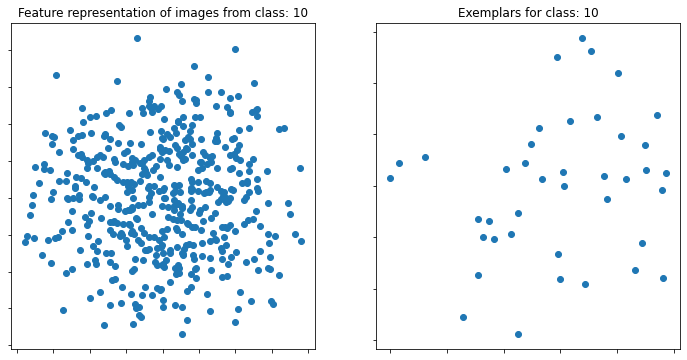

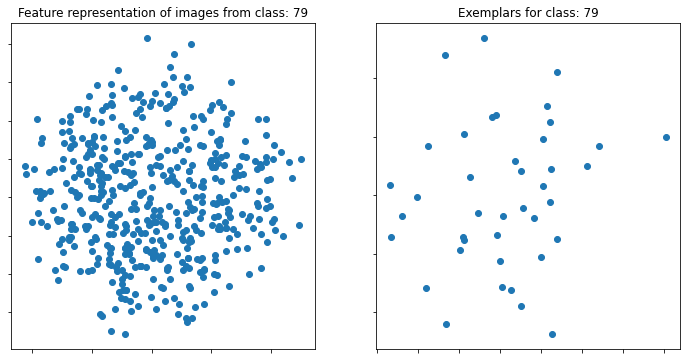

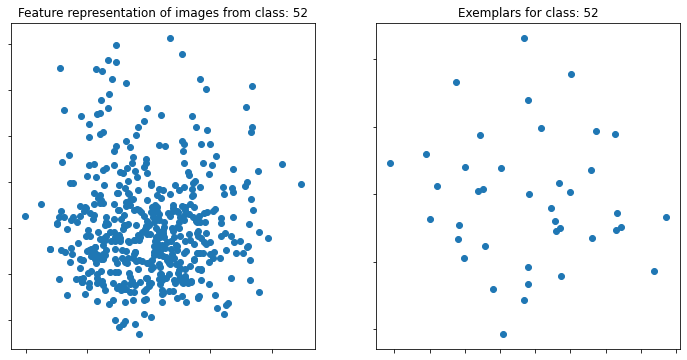

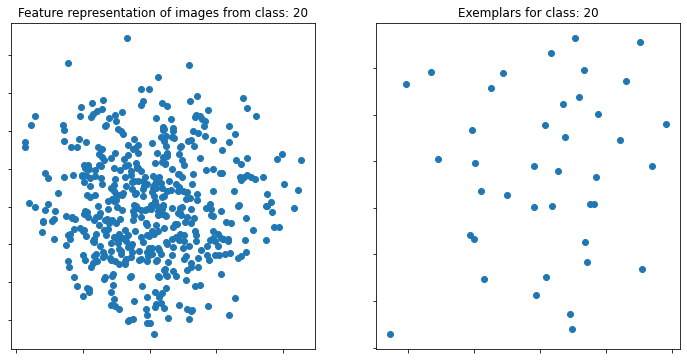

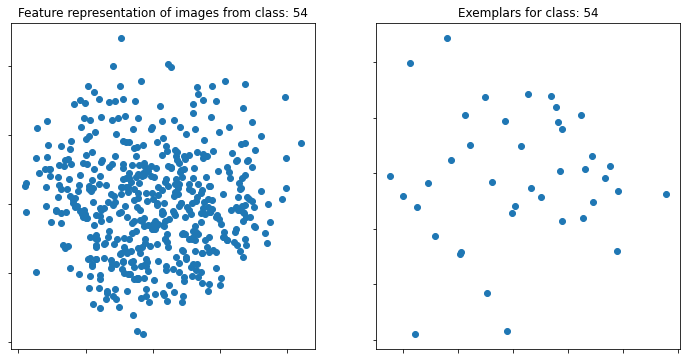

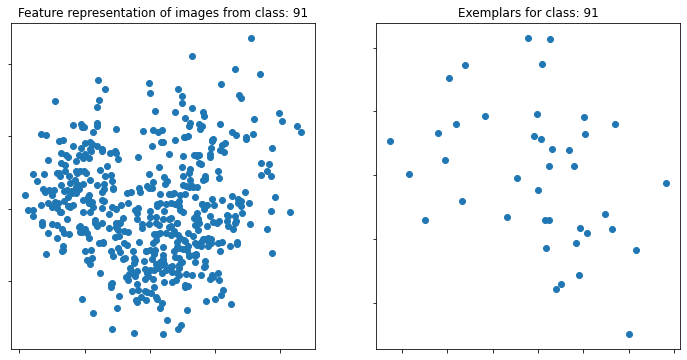

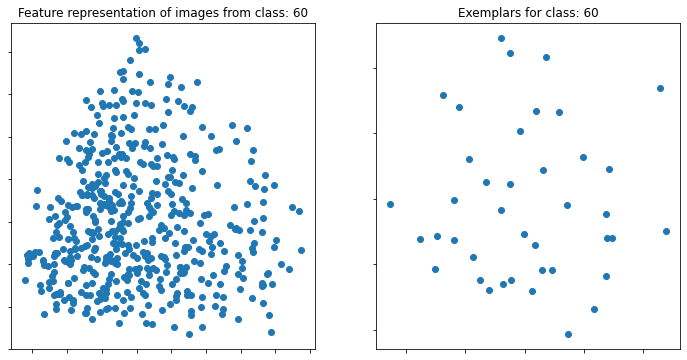

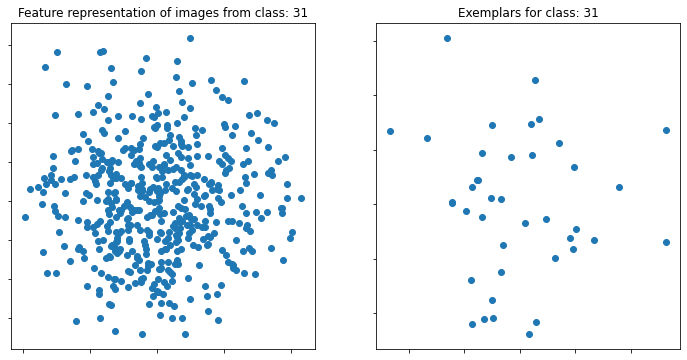

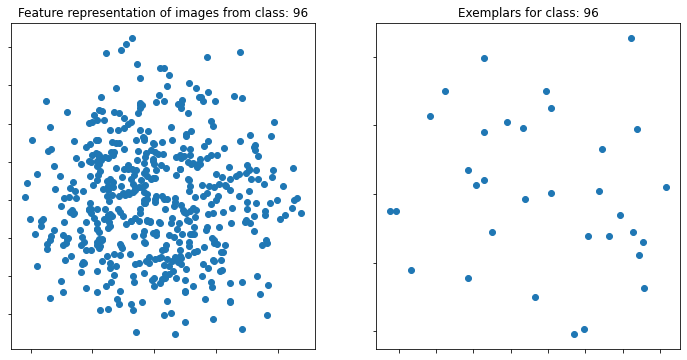

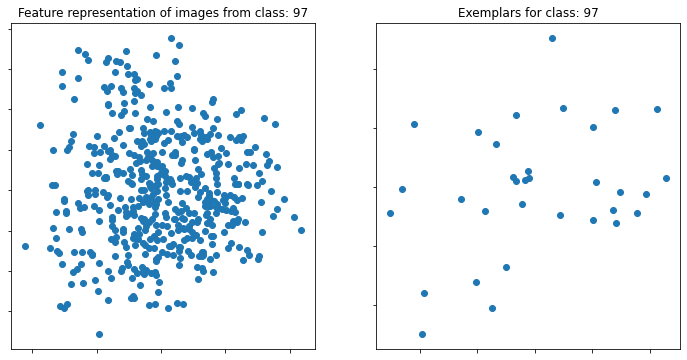

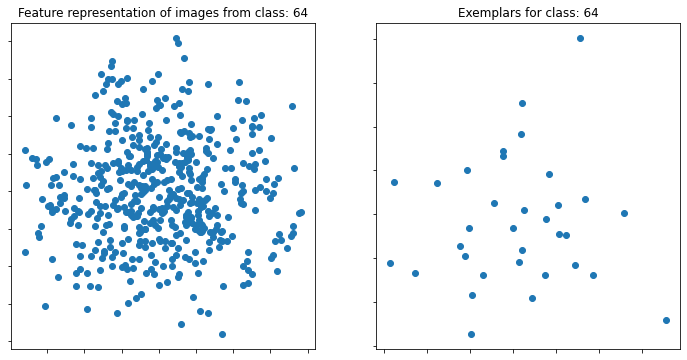

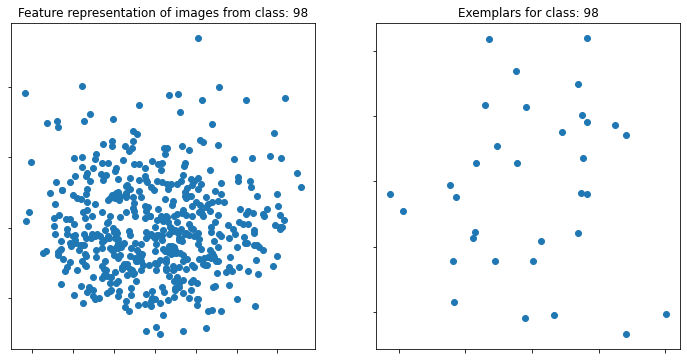

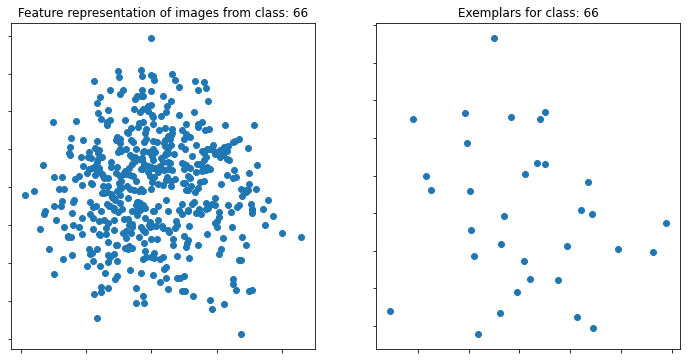

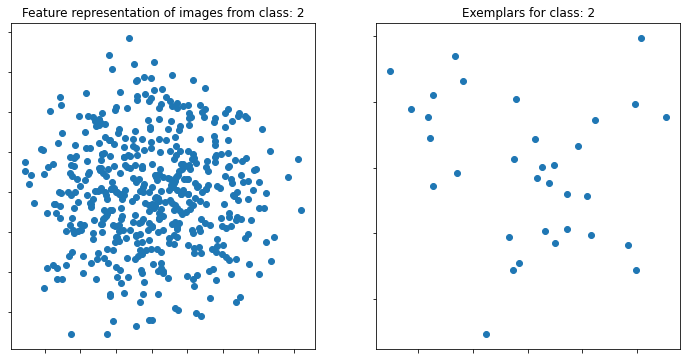

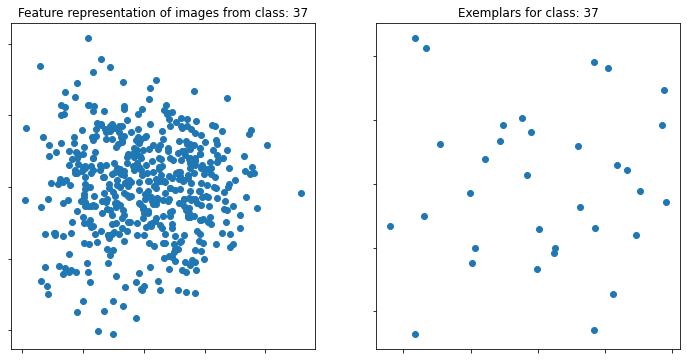

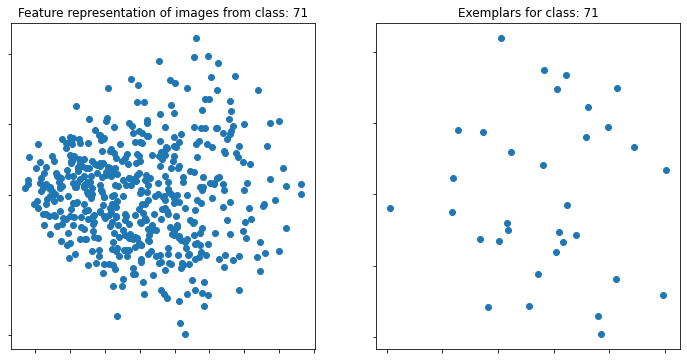

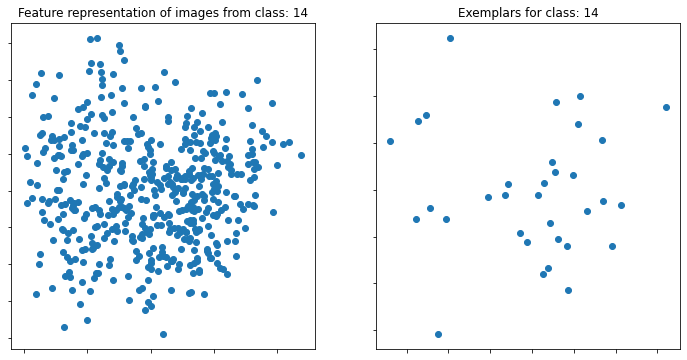

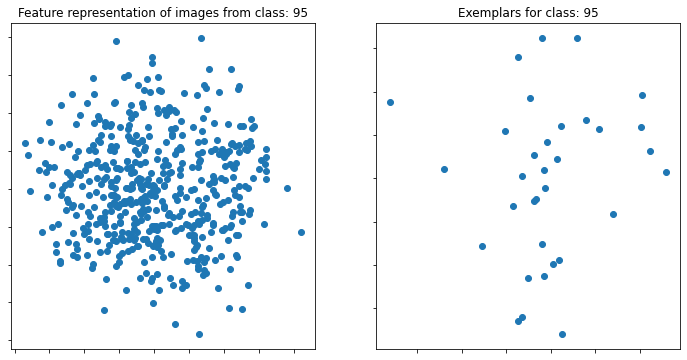

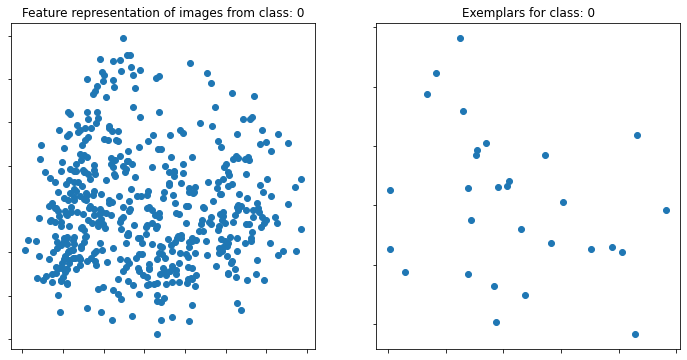

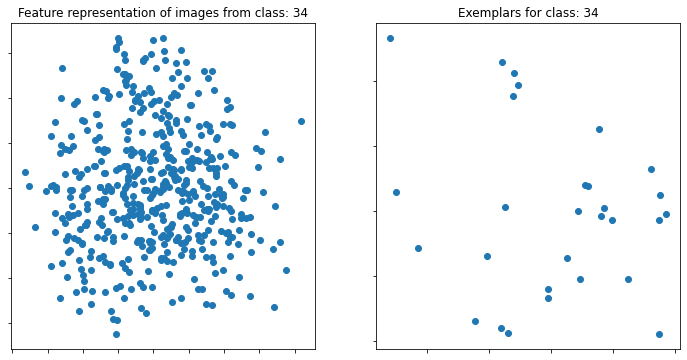

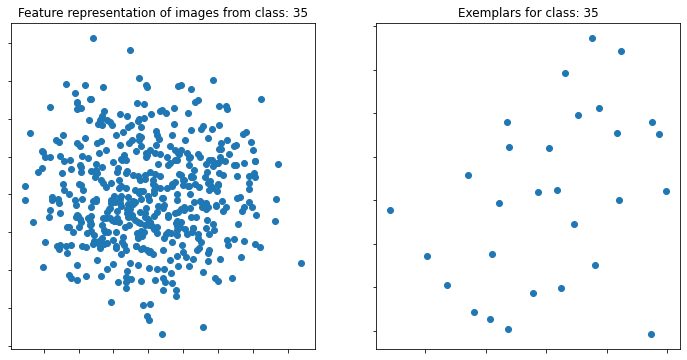

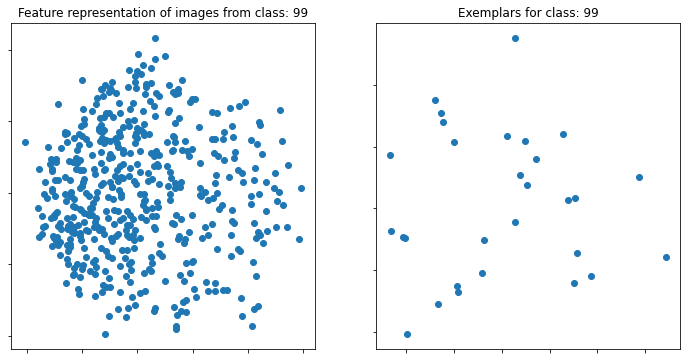

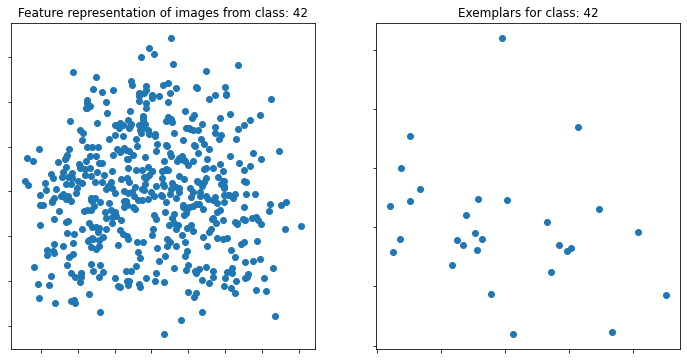

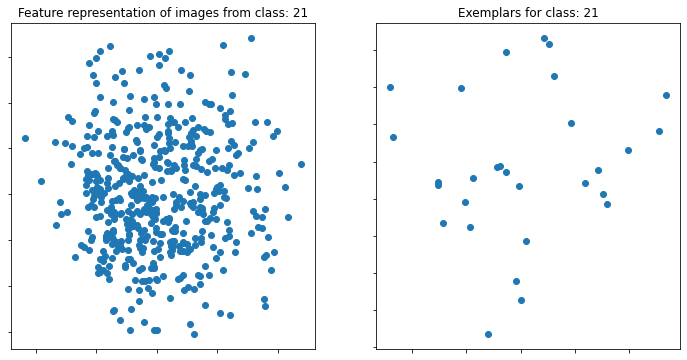

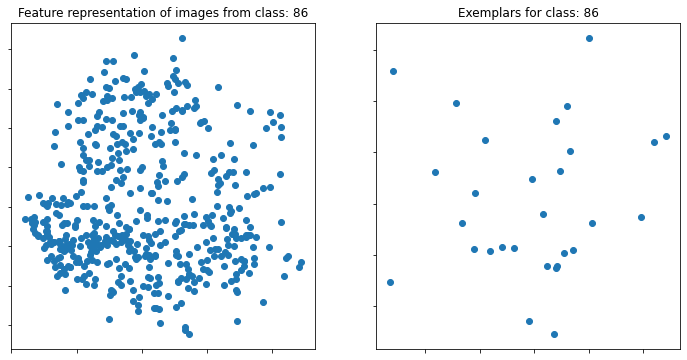

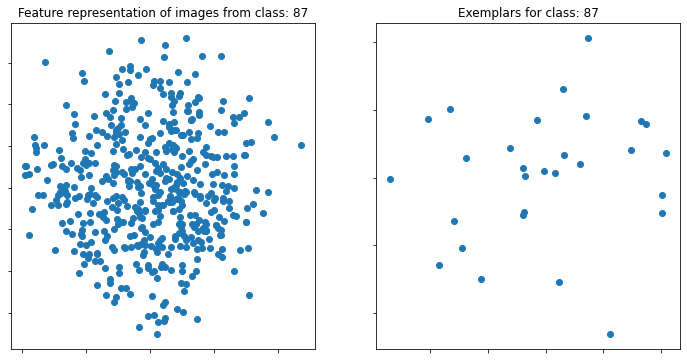

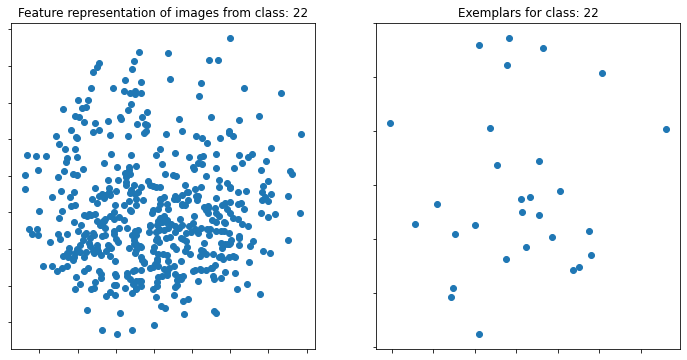

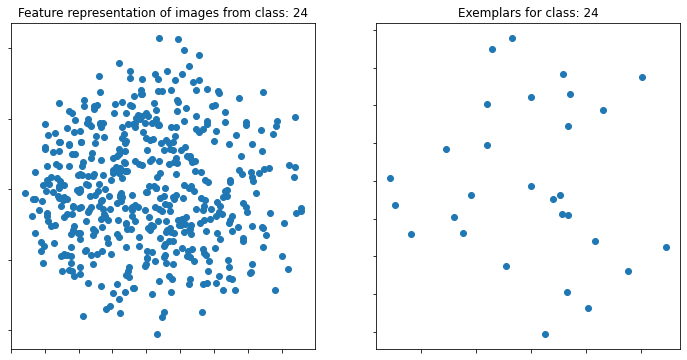

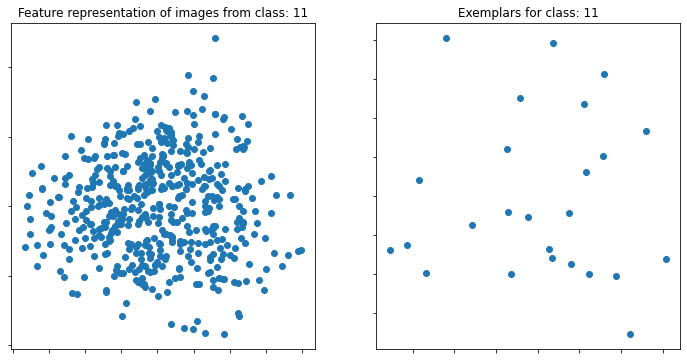

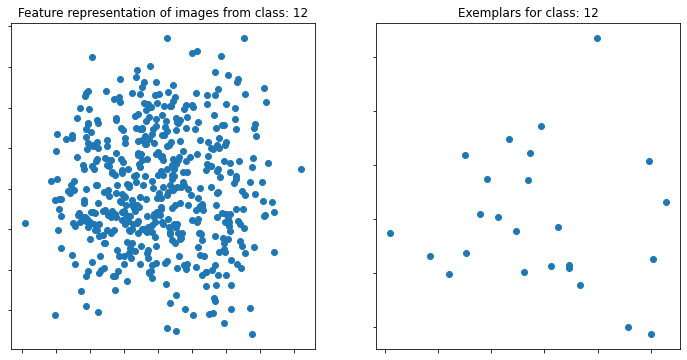

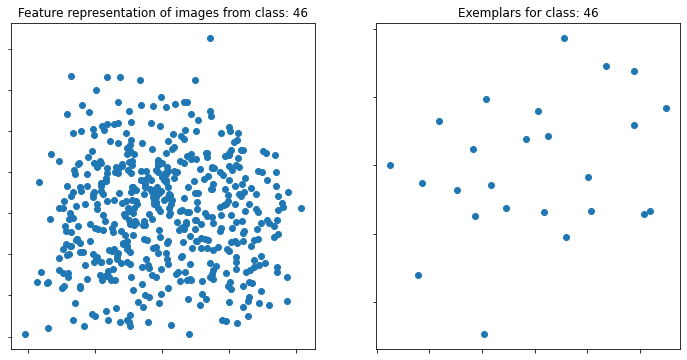

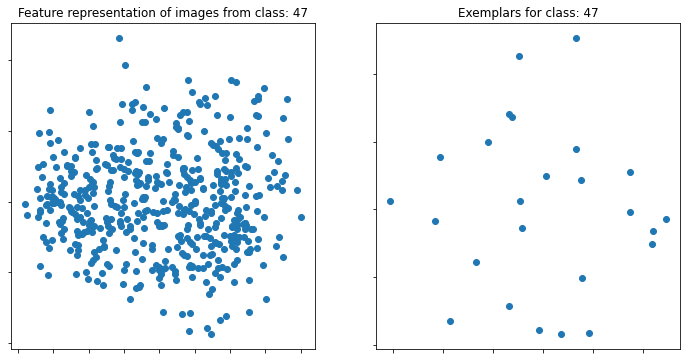

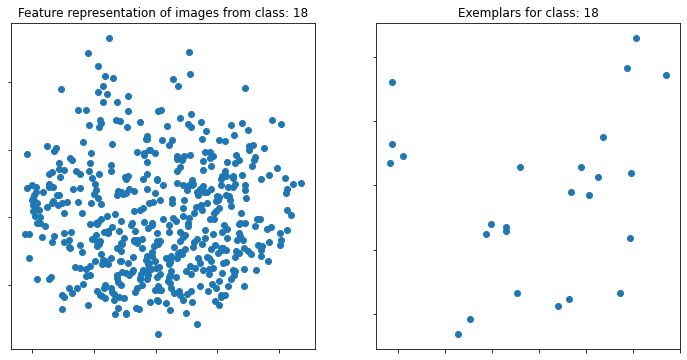

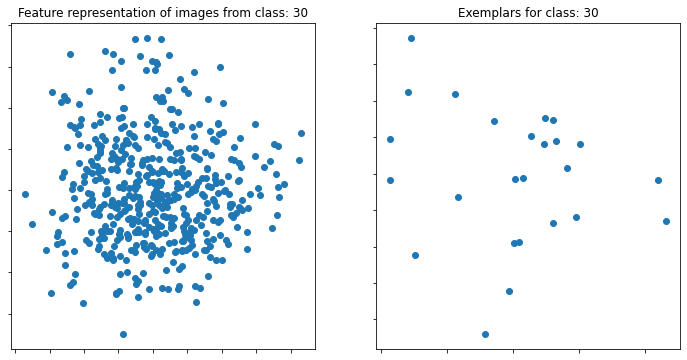

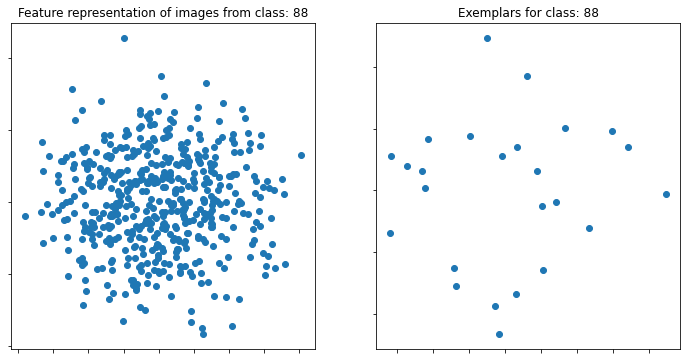

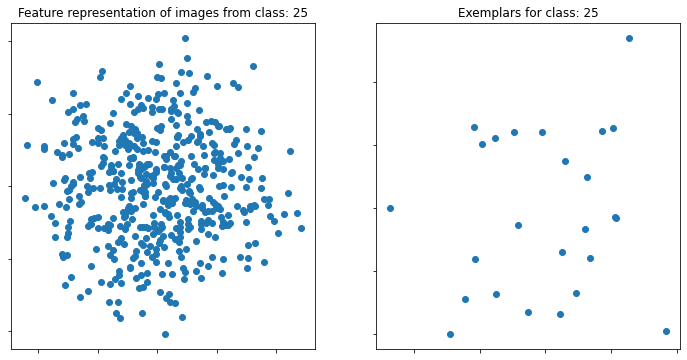

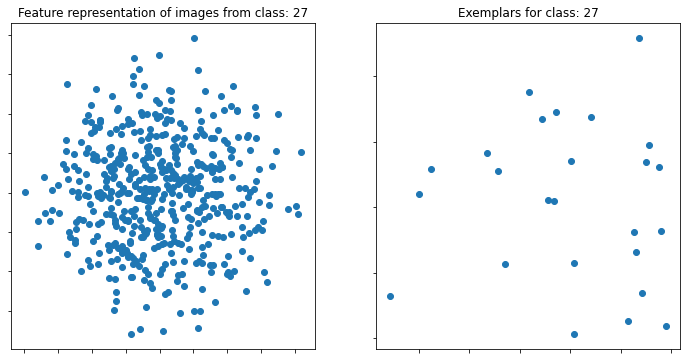

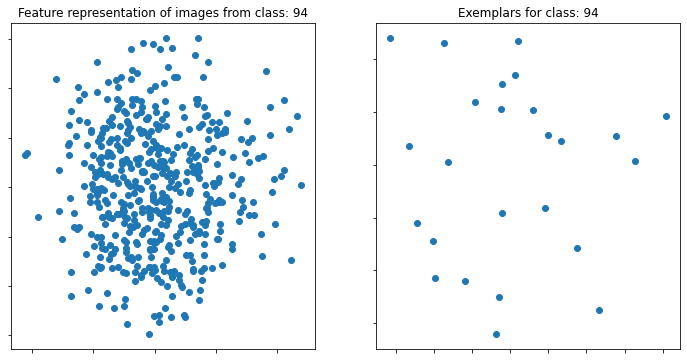

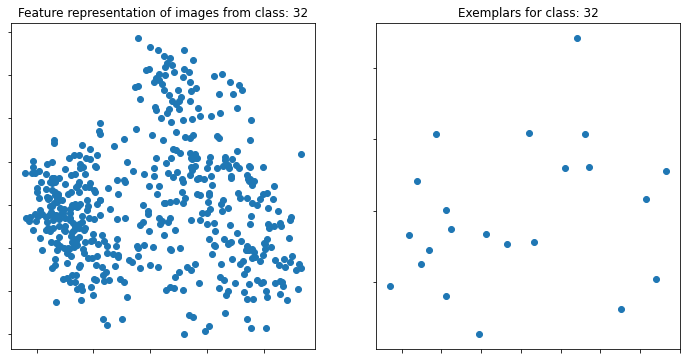

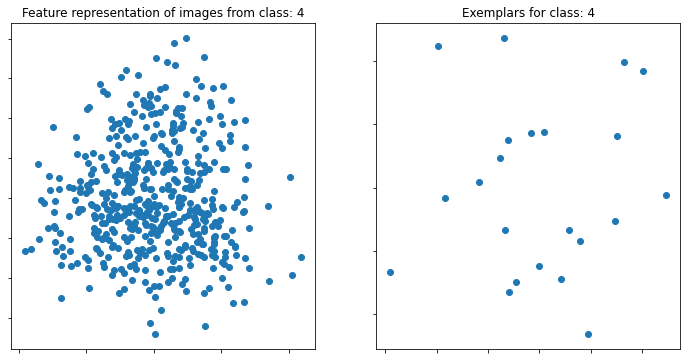

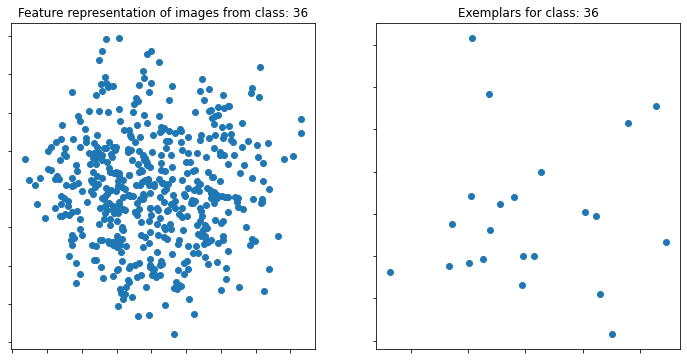

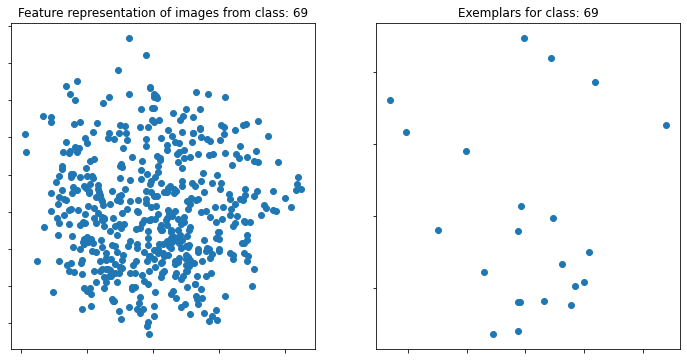

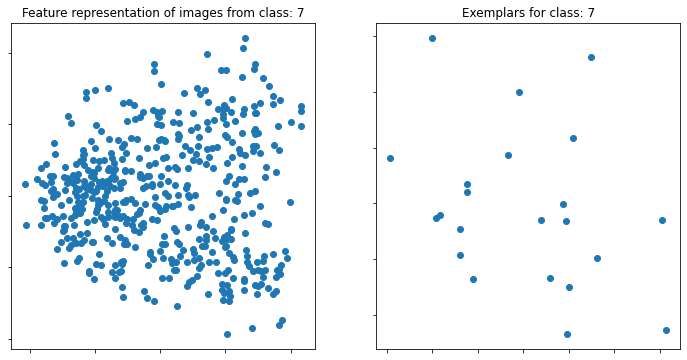

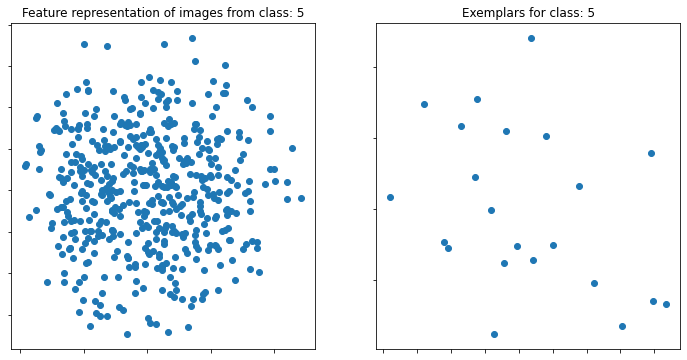

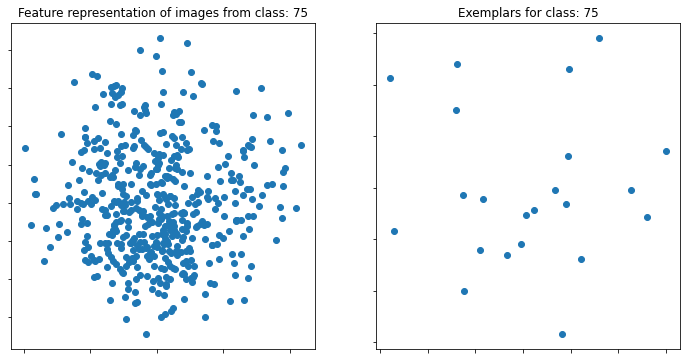

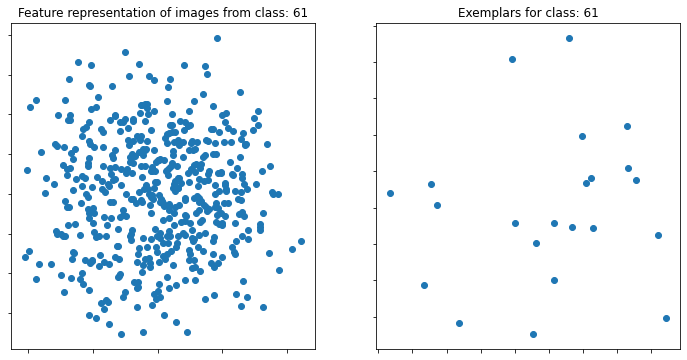

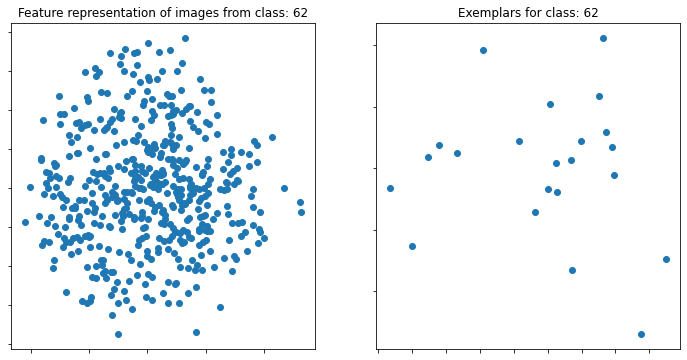

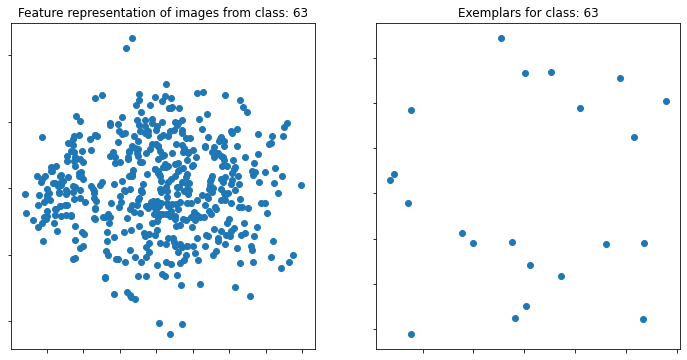

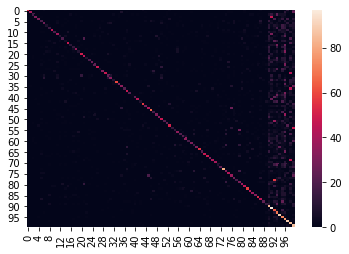

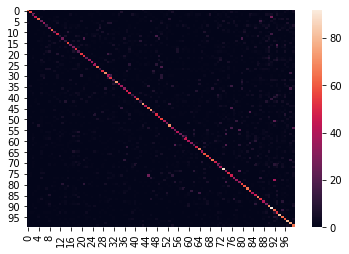

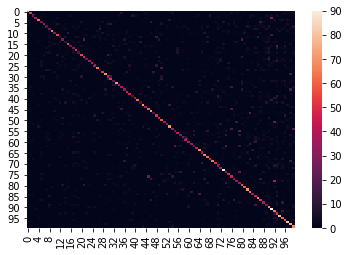

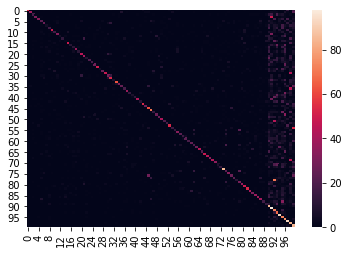

SVM:[0.882, 0.74, 0.6893333333333334, 0.59475, 0.551, 0.49583333333333335, 0.4684285714285714, 0.40875, 0.37955555555555553, 0.3612] and mean:0.5570850793650793
NME:[0.882, 0.761, 0.7226666666666667, 0.664, 0.6224, 0.5746666666666667, 0.5464285714285714, 0.5055, 0.47755555555555557, 0.4591]and mean:0.621531746031746
COSINE SIMILARITY:[0.882, 0.7625, 0.7233333333333334, 0.665, 0.622, 0.5751666666666667, 0.5475714285714286, 0.50775, 0.4777777777777778, 0.4584]and mean:0.6221499206349207
KNN:[0.882]and mean:0.882
19/20 exemplars for class: 29 and 200 total exemplars [33, 67, 39, 73, 48, 49, 29, 51, 57, 93]


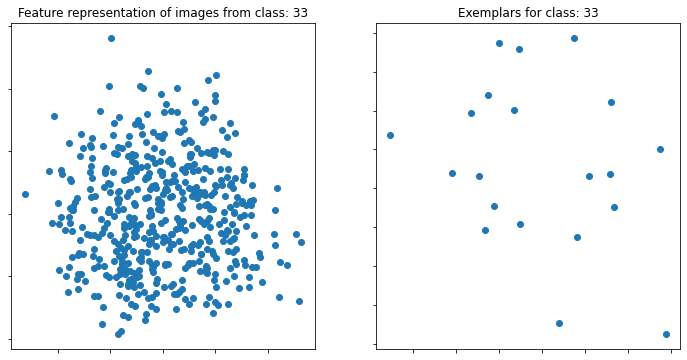

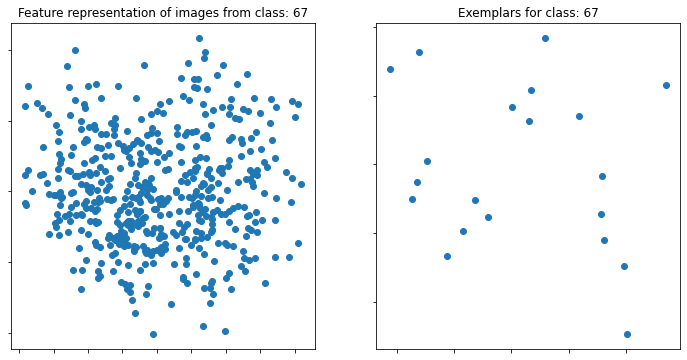

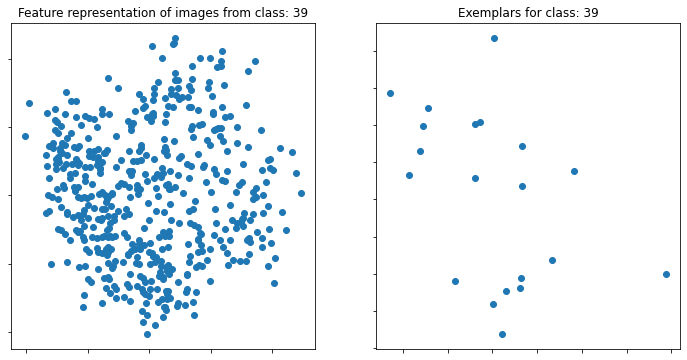

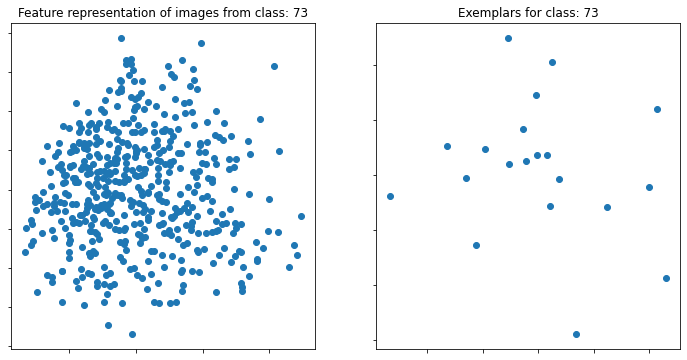

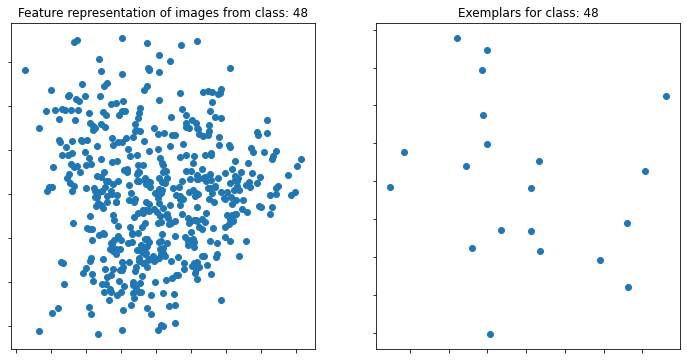

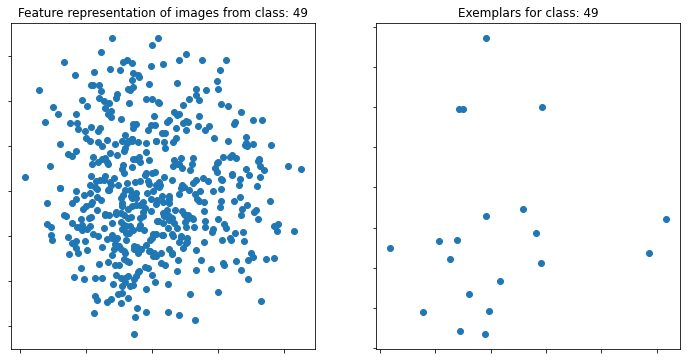

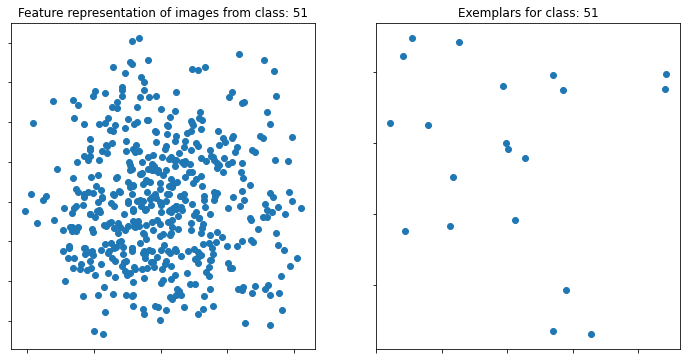

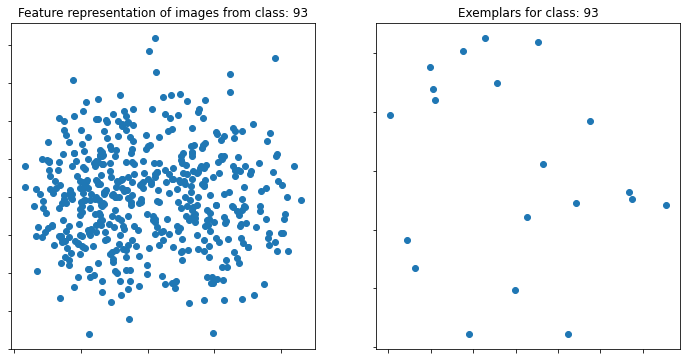

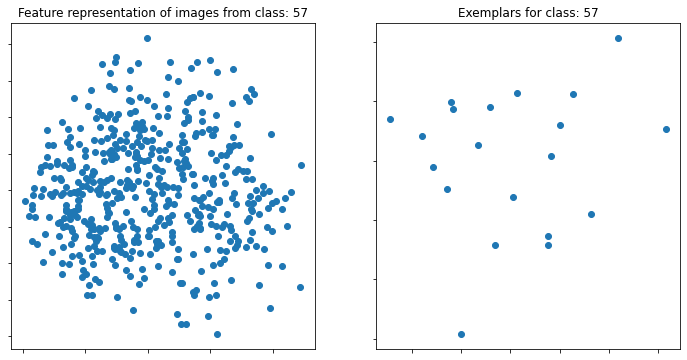

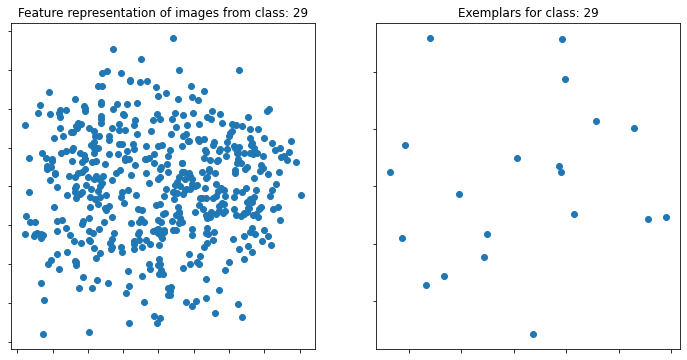

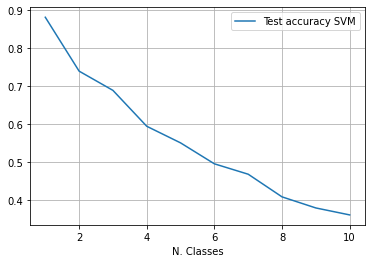

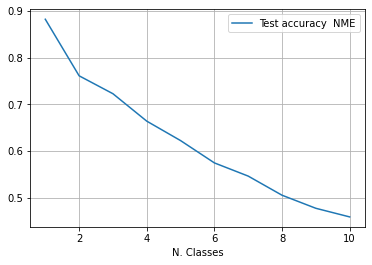

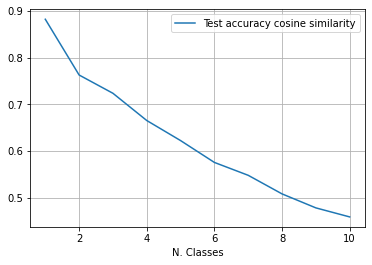

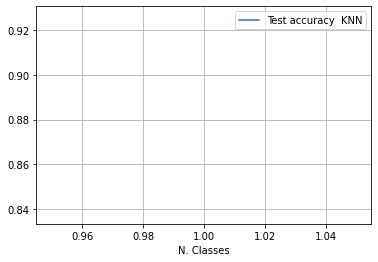

In [ ]:
parser = argparse.ArgumentParser(description='Incremental Learning BIC')
parser.add_argument('--batch_size', default = 128, type = int)
parser.add_argument('--epoch', default = 70, type = int)
parser.add_argument('--lr', default = 0.2, type = int)
parser.add_argument('--max_size', default = 2000, type = int)
parser.add_argument('--total_cls', default = 100, type = int)

args = parser.parse_args(args=[])

trainer = Trainer(args.total_cls)
trainer.train(args.batch_size, args.epoch, args.lr, args.max_size)